Potrebni paketi (biblioteke)

In [1]:
import numpy as np
import tenseal as ts
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import csv
import os
import gc

Učitavanje podataka

In [2]:
fp_organizer = "/home/jovyan/work/organizer.xlsx" 
fp_participant1 = "/home/jovyan/work/participant1.xlsx"
fp_participant2 = "/home/jovyan/work/participant2.xlsx" 
fp_participant3 = "/home/jovyan/work/participant3.xlsx"

# Naponi
Un = 230  # nazivni napon
Umj = 110  # mjerni napon

k = (Un / Umj) ** 2

try:
    df_org = pd.read_excel(fp_organizer, skiprows=[1])
    df_p1 = pd.read_excel(fp_participant1, skiprows=[1])
    df_p2 = pd.read_excel(fp_participant2, skiprows=[1])
    df_p3 = pd.read_excel(fp_participant3, skiprows=[1])
    
    df_org["M [Nm]"] = df_org["M [Nm]"] * k
    df_p1["M [Nm]"] = df_p1["M [Nm]"] * k
    df_p2["M [Nm]"] = df_p2["M [Nm]"] * k
    df_p3["M [Nm]"] = df_p3["M [Nm]"] * k

except Exception as e:
    print(f"Greška: {e}")

Prikaz raspodjele koraka brzine

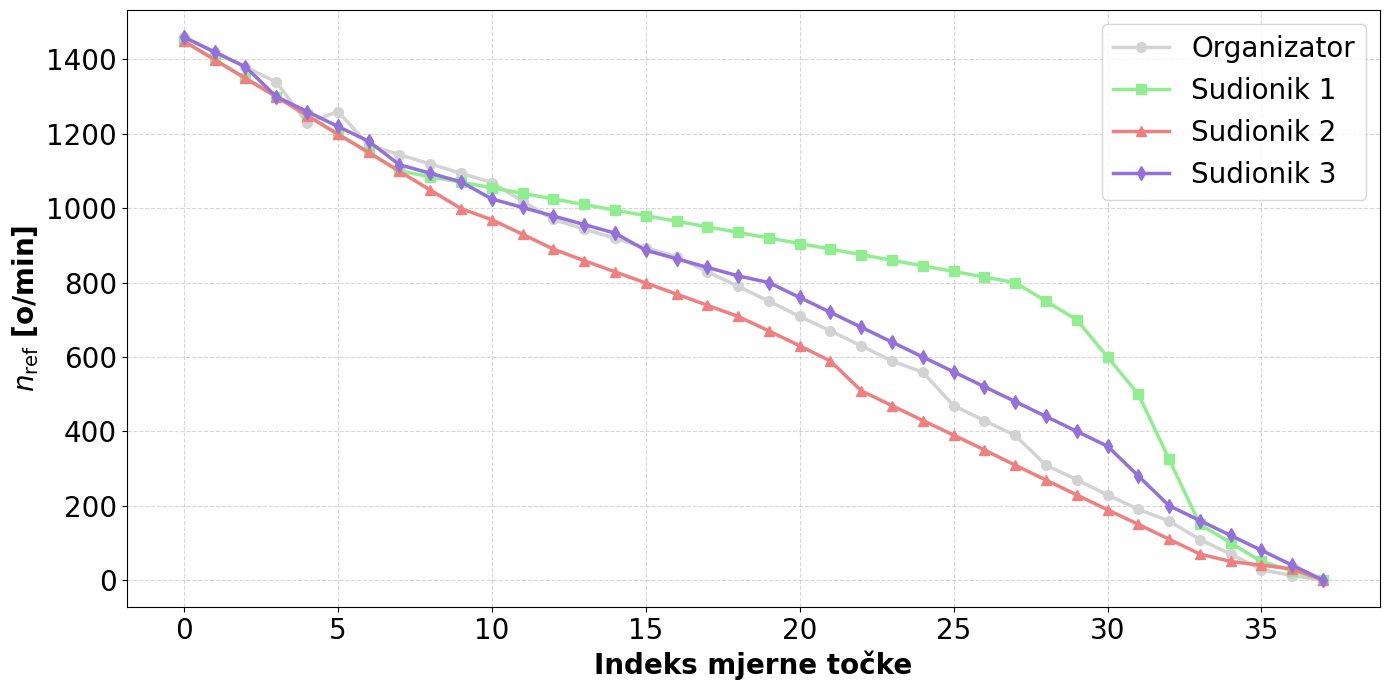

In [3]:
nref_org = df_org["nref (o/min)"]
nref_p1 = df_p1["nref_o_min_"]
nref_p2 = df_p2["n [o/min]"]
nref_p3 = df_p3["n [o/min]"]

x = list(range(len(nref_org)))

plt.figure(figsize=(14, 7))

plt.plot(x, nref_org, marker='o', markersize=7, linewidth=2.5, color='lightgrey', label='Organizator')
plt.plot(x, nref_p1, marker='s', markersize=7, linewidth=2.5, color='lightgreen', label='Sudionik 1')
plt.plot(x, nref_p2, marker='^', markersize=7, linewidth=2.5, color='lightcoral', label='Sudionik 2')
plt.plot(x, nref_p3, marker='d', markersize=7, linewidth=2.5, color='mediumpurple', label='Sudionik 3')

plt.xlabel('Indeks mjerne točke', fontsize=20, fontweight='bold')
plt.ylabel(r'$n_{\mathrm{ref}}$ [o/min]', fontsize=20, fontweight='bold')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("diff_nref.png", dpi=300, bbox_inches='tight')
plt.show()

Definiranje konteksta i generiranje ključeva

In [4]:
poly_mod_degree = 4096
coeff_mod_bit_sizes = [30, 20, 30]  
scale = 2**20

context = ts.context(
    scheme=ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=poly_mod_degree,
    coeff_mod_bit_sizes=coeff_mod_bit_sizes,
)

context.global_scale = scale

context.generate_galois_keys()
context.generate_relin_keys()

public_context = context.copy() 
public_context.make_context_public()

with open("tenseal_public.ckks", "wb") as f:
    f.write(public_context.serialize())

with open("tenseal_private.ckks", "wb") as f:
    f.write(context.serialize())

print("CKKS kontekst i ključevi su generirani.")

CKKS kontekst i ključevi su generirani.


Predobrada podataka

In [5]:
U_B = 0.277
k = 2  
def preprocessing(column_H):
    podaci = column_H.to_numpy()
    m = len(podaci)
    
    Xm = np.mean(podaci)
    sigma = np.sqrt(np.sum((podaci - Xm) ** 2) / m)
    sigma_inverse = 1 / sigma if sigma != 0 else np.inf 
    U_A = sigma / np.sqrt(m)
    U = k * np.sqrt(U_A**2 + U_B**2)
    U_squared = U**2

    return {
        "Xm": Xm,
        "σ": sigma,
        "σ_inverse": sigma_inverse,
        "U_A": U_A,
        "U": U,
        "U_squared": U_squared
    }

rezultati_p1 = preprocessing(df_p1["M [Nm]"])
rezultati_p2 = preprocessing(df_p2["M [Nm]"])
rezultati_p3 = preprocessing(df_p3["M [Nm]"])
rezultati_org = preprocessing(df_org["M [Nm]"])

Xm_MV_p1 = rezultati_p1["Xm"]
sigma_MV_p1 = rezultati_p1["σ"]
sigma_MV_inverse_p1 = rezultati_p1["σ_inverse"]
U_A_MV_p1 = rezultati_p1["U_A"]
U_MV_p1 = rezultati_p1["U"]
U_MV_squared_p1 = rezultati_p1["U_squared"]

Xm_MV_p2 = rezultati_p2["Xm"]
sigma_MV_p2 = rezultati_p2["σ"]
sigma_MV_inverse_p2 = rezultati_p2["σ_inverse"]
U_A_MV_p2 = rezultati_p2["U_A"]
U_MV_p2 = rezultati_p2["U"]
U_MV_squared_p2 = rezultati_p2["U_squared"]

Xm_MV_p3 = rezultati_p3["Xm"]
sigma_MV_p3 = rezultati_p3["σ"]
sigma_MV_inverse_p3 = rezultati_p3["σ_inverse"]
U_A_MV_p3 = rezultati_p3["U_A"]
U_MV_p3 = rezultati_p3["U"]
U_MV_squared_p3 = rezultati_p3["U_squared"]

Xm_AV_org = rezultati_org["Xm"]
sigma_AV_org = rezultati_org["σ"]
sigma_AV_inverse_org = rezultati_org["σ_inverse"]
U_A_AV_org = rezultati_org["U_A"]
U_AV_org = rezultati_org["U"]
U_AV_squared_org = rezultati_org["U_squared"]

print("Rezultati za participant1:")
for k, v in rezultati_p1.items():
    print(f"{k}: {v:.6f}")

print("\nRezultati za participant2:")
for k, v in rezultati_p2.items():
    print(f"{k}: {v:.6f}")

print("\nRezultati za participant3:")
for k, v in rezultati_p3.items():
    print(f"{k}: {v:.6f}")
    
print("\nRezultati za organizer:")
for k, v in rezultati_org.items():
    print(f"{k}: {v:.6f}")

with open(f"rezultati_predobrada.txt", "w") as file:
    file.write("Rezultati za participant1:\n")
    for k, v in rezultati_p1.items():
        file.write(f"{k}: {v:.6f}\n")

    file.write("\nRezultati za participant2:\n")
    for k, v in rezultati_p2.items():
        file.write(f"{k}: {v:.6f}\n")

    file.write("\nRezultati za participant3:\n")
    for k, v in rezultati_p3.items():
        file.write(f"{k}: {v:.6f}\n")

    file.write("\nRezultati za organizer:\n")
    for k, v in rezultati_org.items():
        file.write(f"{k}: {v:.6f}\n")


Rezultati za participant1:
Xm: 3.924149
σ: 0.796201
σ_inverse: 1.255965
U_A: 0.129161
U: 0.611266
U_squared: 0.373646

Rezultati za participant2:
Xm: 4.007066
σ: 0.812291
σ_inverse: 1.231087
U_A: 0.131771
U: 0.613490
U_squared: 0.376370

Rezultati za participant3:
Xm: 3.939577
σ: 0.849308
σ_inverse: 1.177429
U_A: 0.137776
U: 0.618745
U_squared: 0.382845

Rezultati za organizer:
Xm: 4.068077
σ: 0.617635
σ_inverse: 1.619078
U_A: 0.100194
U: 0.589127
U_squared: 0.347071


Prikaz rezultata predobrade podataka

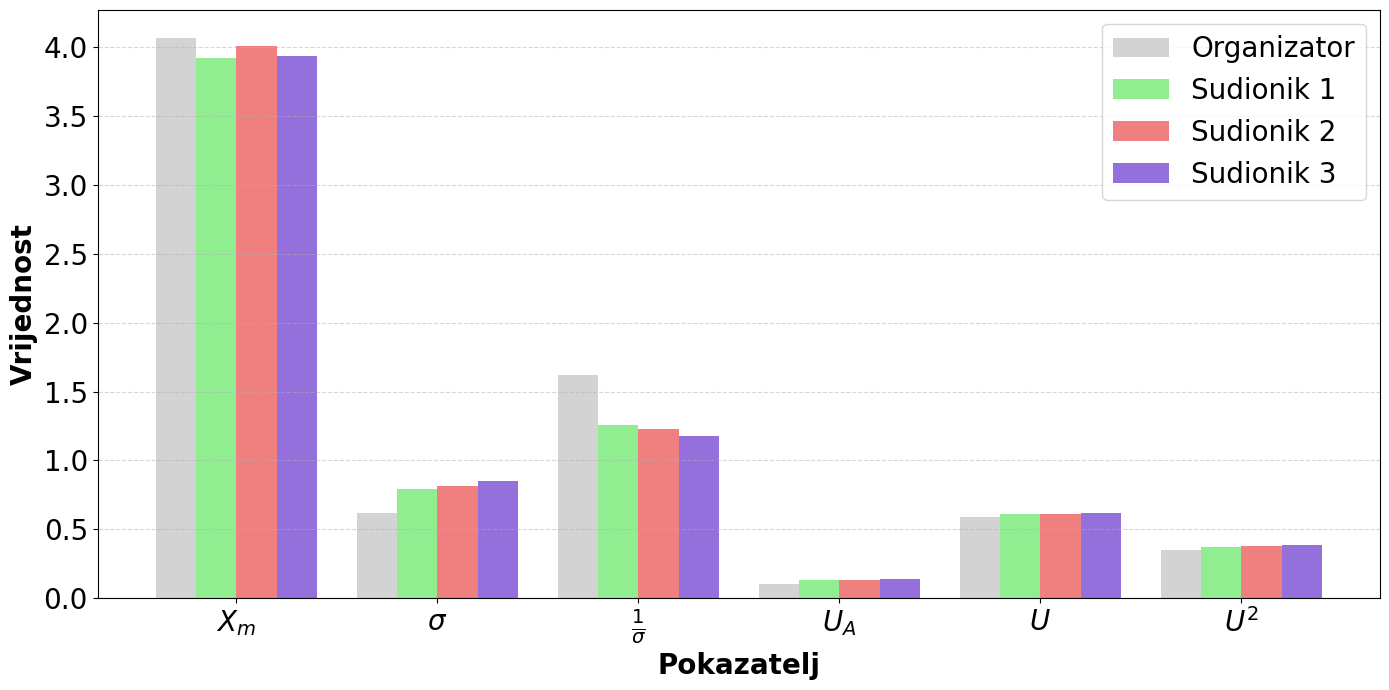

In [6]:
labels = ["$X_m$", r"$\sigma$", r"$\frac{1}{\sigma}$", r"$U_A$", r"$U$", r"$U^2$"]
org_values = [
    Xm_AV_org, sigma_AV_org, sigma_AV_inverse_org,
    U_A_AV_org, U_AV_org, U_AV_squared_org
]
p1_values = [
    Xm_MV_p1, sigma_MV_p1, sigma_MV_inverse_p1,
    U_A_MV_p1, U_MV_p1, U_MV_squared_p1
]
p2_values = [
    Xm_MV_p2, sigma_MV_p2, sigma_MV_inverse_p2,
    U_A_MV_p2, U_MV_p2, U_MV_squared_p2
]
p3_values = [
    Xm_MV_p3, sigma_MV_p3, sigma_MV_inverse_p3,
    U_A_MV_p3, U_MV_p3, U_MV_squared_p3
]

labels = ["$X_m$", r"$\sigma$", r"$\frac{1}{\sigma}$", r"$U_A$", r"$U$", r"$U^2$"]
org_values = [Xm_AV_org, sigma_AV_org, sigma_AV_inverse_org, U_A_AV_org, U_AV_org, U_AV_squared_org]
p1_values = [Xm_MV_p1, sigma_MV_p1, sigma_MV_inverse_p1, U_A_MV_p1, U_MV_p1, U_MV_squared_p1]
p2_values = [Xm_MV_p2, sigma_MV_p2, sigma_MV_inverse_p2, U_A_MV_p2, U_MV_p2, U_MV_squared_p2]
p3_values = [Xm_MV_p3, sigma_MV_p3, sigma_MV_inverse_p3, U_A_MV_p3, U_MV_p3, U_MV_squared_p3]

x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(14, 7))

plt.bar(x - 1.5 * width, org_values, width, label='Organizator', color='lightgrey')
plt.bar(x - 0.5 * width, p1_values, width, label='Sudionik 1', color='lightgreen')
plt.bar(x + 0.5 * width, p2_values, width, label='Sudionik 2', color='lightcoral')
plt.bar(x + 1.5 * width, p3_values, width, label='Sudionik 3', color='mediumpurple')

plt.xlabel('Pokazatelj', fontsize=20, fontweight='bold')
plt.ylabel('Vrijednost', fontsize=20, fontweight='bold')

plt.xticks(x, labels, fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("rezultati_predobrada_stilizirano.png", dpi=300, bbox_inches='tight')
plt.show()

Šifriranje

In [7]:
def encrypt_value(value):
    return ts.ckks_vector(context, [value])

Xm_MV_p1_enc = encrypt_value(Xm_MV_p1)
sigma_MV_p1_enc = encrypt_value(sigma_MV_p1)
sigma_MV_inverse_p1_enc = encrypt_value(sigma_MV_inverse_p1)
U_A_MV_p1_enc = encrypt_value(U_A_MV_p1)
U_MV_p1_enc = encrypt_value(U_MV_p1)
U_MV_squared_p1_enc = encrypt_value(U_MV_squared_p1)

Xm_MV_p2_enc = encrypt_value(Xm_MV_p2)
sigma_MV_p2_enc = encrypt_value(sigma_MV_p2)
sigma_MV_inverse_p2_enc = encrypt_value(sigma_MV_inverse_p2)
U_A_MV_p2_enc = encrypt_value(U_A_MV_p2)
U_MV_p2_enc = encrypt_value(U_MV_p2)
U_MV_squared_p2_enc = encrypt_value(U_MV_squared_p2)

Xm_MV_p3_enc = encrypt_value(Xm_MV_p3)
sigma_MV_p3_enc = encrypt_value(sigma_MV_p3)
sigma_MV_inverse_p3_enc = encrypt_value(sigma_MV_inverse_p3)
U_A_MV_p3_enc = encrypt_value(U_A_MV_p3)
U_MV_p3_enc = encrypt_value(U_MV_p3)
U_MV_squared_p3_enc = encrypt_value(U_MV_squared_p3)

Xm_AV_org_enc = encrypt_value(Xm_AV_org)
sigma_AV_org_enc = encrypt_value(sigma_AV_org)
sigma_AV_inverse_org_enc = encrypt_value(sigma_AV_inverse_org)
U_A_AV_org_enc = encrypt_value(U_A_AV_org)
U_AV_org_enc = encrypt_value(U_AV_org)
U_AV_squared_org_enc = encrypt_value(U_AV_squared_org)

Funkcija za provođenje izračuna z i En vrijednosti

In [8]:
def izracunaj_z_i_En(Xm_MV_enc, Xm_AV_enc, sigma_inverse_enc, U_MV_squared_enc, U_AV_squared_enc):

    # sudionik
    delta_X_enc = Xm_MV_enc - Xm_AV_enc
    z_enc = delta_X_enc * sigma_inverse_enc

    # organizator
    U_MV_squared = U_MV_squared_enc.decrypt()[0]
    U_AV_squared = U_AV_squared_enc.decrypt()[0]

    U_sum_sqrt = math.sqrt(U_MV_squared + U_AV_squared)
    
    En = delta_X_enc.decrypt()[0] * (1.0 / U_sum_sqrt)

    return z_enc, En

Primjena funkcije za provođenje izračuna z i En vrijednosti
i računanje vremena izvođenja

In [9]:
broj_ponavljanja = 10
vremena = []

for _ in range(broj_ponavljanja):
    gc.collect()
    start = time.perf_counter()

    try:
        z_p1, En_p1 = izracunaj_z_i_En(
            Xm_MV_p1_enc, Xm_AV_org_enc,
            sigma_MV_inverse_p1_enc,
            U_MV_squared_p1_enc, U_AV_squared_org_enc
        )

        z_p2, En_p2 = izracunaj_z_i_En(
            Xm_MV_p2_enc, Xm_AV_org_enc,
            sigma_MV_inverse_p2_enc,
            U_MV_squared_p2_enc, U_AV_squared_org_enc
        )

        z_p3, En_p3 = izracunaj_z_i_En(
            Xm_MV_p3_enc, Xm_AV_org_enc,
            sigma_MV_inverse_p3_enc,
            U_MV_squared_p3_enc, U_AV_squared_org_enc
        )

        end = time.perf_counter()
        trajanje = end - start
        vremena.append(trajanje)

    except Exception as e:
        print("Greška prilikom izračuna u jednoj iteraciji:", e)

if len(vremena) > 1:
    vremena = vremena[1:]

if vremena:
    prosjek = sum(vremena) / len(vremena)
    print(f"Prosječno trajanje (bez warm-up): {prosjek:.6f} sekundi")
else:
    print("Nema dovoljno uspješnih mjerenja za izračun prosjeka.")

Prosječno trajanje (bez warm-up): 0.013342 sekundi


Dešifriranje

In [10]:
z_p1_dec = z_p1.decrypt()[0]

z_p2_dec = z_p2.decrypt()[0]

z_p3_dec = z_p3.decrypt()[0]

print("Rezultati za participant1:")
print("z =", z_p1_dec)
print("E_n =", En_p1)

print("\nRezultati za participant2:")
print("z =", z_p2_dec)
print("E_n =", En_p2)

print("\nRezultati za participant3:")
print("z =", z_p3_dec)
print("E_n =", En_p3)

with open(f"test1__{poly_mod_degree}_{coeff_mod_bit_sizes}_{scale}.txt", "w", encoding="utf-8") as file:
    file.write("Rezultati za participant1:\n")
    file.write(f"z = {z_p1_dec:.6f}\n")
    file.write(f"E_n = {En_p1:.6f}\n\n")

    file.write("Rezultati za participant2:\n")
    file.write(f"z = {z_p2_dec:.6f}\n")
    file.write(f"E_n = {En_p2:.6f}\n\n")

    file.write("Rezultati za participant3:\n")
    file.write(f"z = {z_p3_dec:.6f}\n")
    file.write(f"E_n = {En_p3:.6f}\n\n")

    file.write("end\n")

Rezultati za participant1:
z = -0.18357082479237352
E_n = -0.17030437682750443

Rezultati za participant2:
z = -0.07709889234176766
E_n = -0.07099922892391691

Rezultati za participant3:
z = -0.15281288683619004
E_n = -0.14942180617758063


Prikaz dobivenih z i En vrijednosti

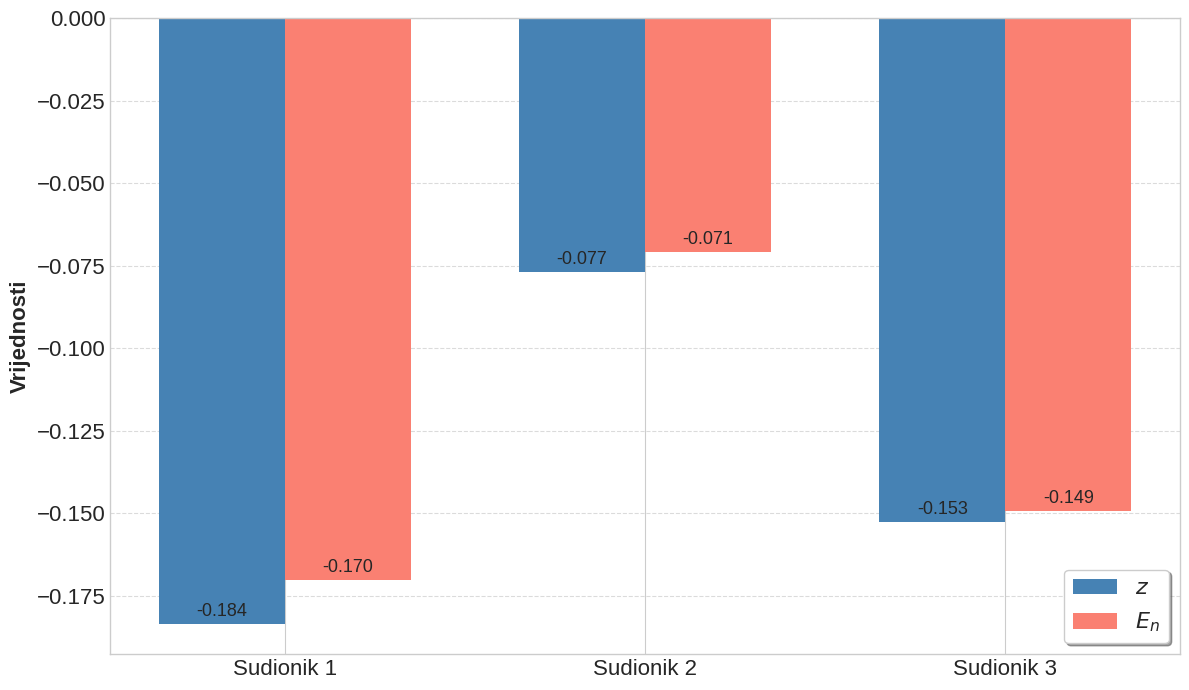

In [11]:
participants = ['Sudionik 1', 'Sudionik 2', 'Sudionik 3']
z_values = [z_p1_dec, z_p2_dec, z_p3_dec]
En_values = [En_p1, En_p2, En_p3]

x = np.arange(len(participants)) 
width = 0.35 

plt.figure(figsize=(12, 7))
plt.style.use('seaborn-v0_8-whitegrid')

bars1 = plt.bar(x - width/2, z_values, width, label=r'$z$', color='steelblue')
bars2 = plt.bar(x + width/2, En_values, width, label=r'$E_n$', color='salmon')

plt.ylabel('Vrijednosti', fontsize=16, fontweight='bold')
plt.xticks(x, participants, fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, frameon=True, shadow=True, fancybox=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=13)

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.savefig(f"test1__{poly_mod_degree}_{coeff_mod_bit_sizes}_{scale}.png", dpi=300, bbox_inches='tight')
plt.show()

Unos vrijednosti dobivenih za jedno izvođenje i referentnih vrijednosti
(dobivene ručnim proračunom)

In [12]:
z_p1 = [-0.183537, -0.184195, -0.183308, -0.184269, -0.185421, -0.181581, -0.186923, -0.180856, -0.180777, -0.180770, -0.180768, -0.180768, -0.180768, -0.183253, -0.183954, -0.187894, -0.184850
] 
z_p2 = [-0.075435, -0.076970, -0.079267, -0.071210, -0.076167, -0.076251, -0.076703, -0.075175, -0.075112, -0.075111, -0.075110, -0.075110, -0.075110, -0.077379, -0.075186, -0.077427, -0.079640
]
z_p3 = [-0.154341, -0.149997, -0.156021, -0.148291, -0.155149, -0.152260, -0.156678, -0.151339, -0.151306, -0.151300, -0.151299, -0.151299, -0.151299, -0.153928, -0.152826, -0.155354, -0.152310
]

en_p1 = [-0.169894, -0.169870, -0.169838, -0.170783, -0.170155, -0.166427, -0.170751, -0.169514, -0.169537, -0.169536, -0.169536, -0.169536, -0.169536, -0.170397, -0.169428, -0.171944, -0.170220
] 
en_p2 = [-0.071139, -0.072010, -0.073582, -0.067553, -0.072262, -0.071667, -0.072624, -0.071741, -0.071731, -0.071731, -0.071731, -0.071731, -0.071731, -0.072214, -0.070236, -0.074169, -0.075510
]
en_p3 = [-0.154341, -0.149015, -0.151835, -0.147345, -0.151876, -0.148629, -0.152255, -0.150379, -0.150406, -0.150406, -0.150406, -0.150406, -0.150406, -0.150668, -0.150058, -0.150611, -0.149543
]

z_ref_p1 = [-0.233031]
z_ref_p2 = [-0.098782]
z_ref_p3 = [-0.208052]

en_ref_p1 = [-0.169536]
en_ref_p2 = [-0.071731]
en_ref_p3 = [-0.150040]

Funkcija za izračun relativne pogreške

In [13]:
def relative_error(values, reference):
    values = np.array(values)
    return np.abs((values - reference) / reference)

Izračun i prikaz relativnih pogrešaka po segmentima

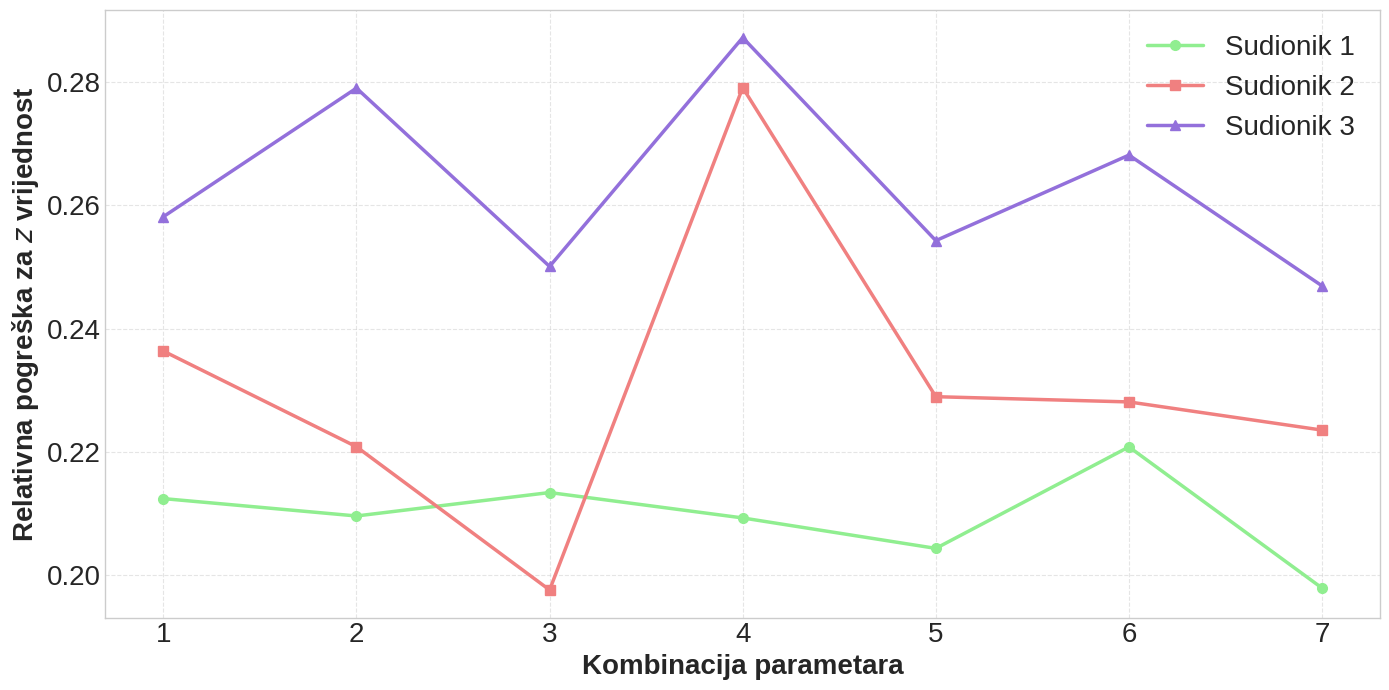

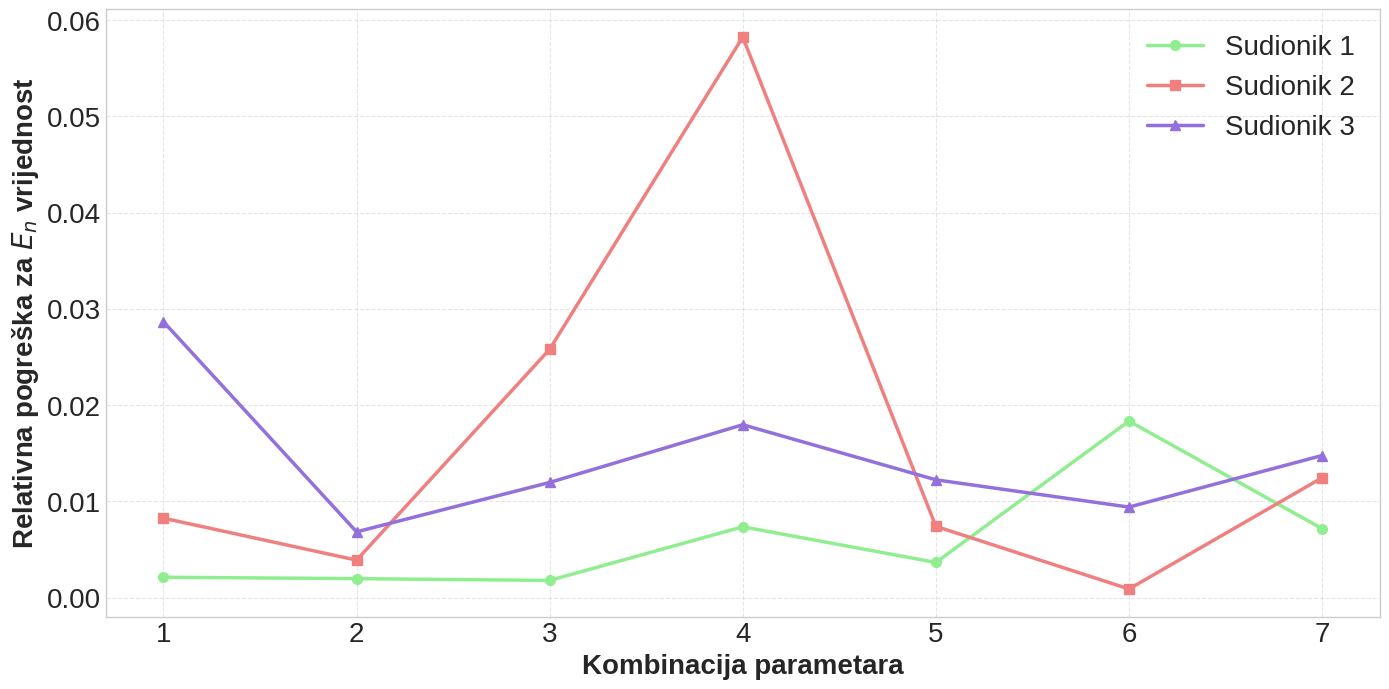

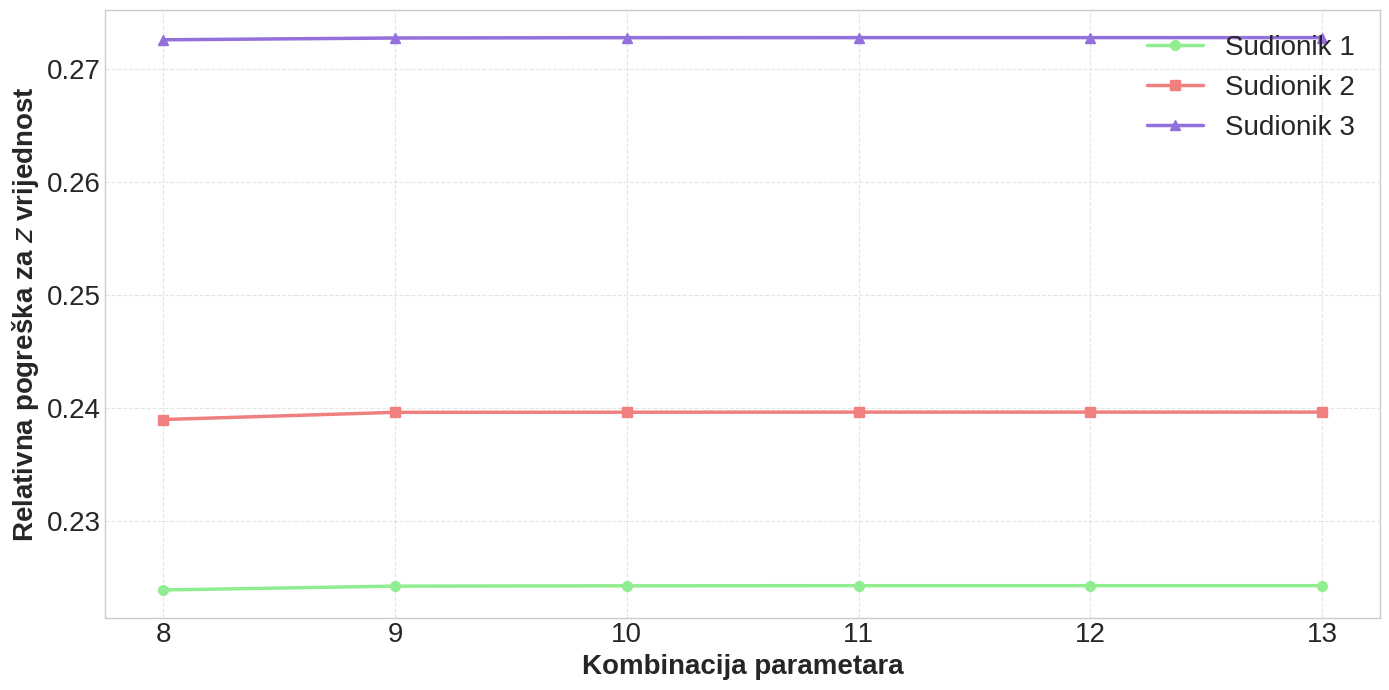

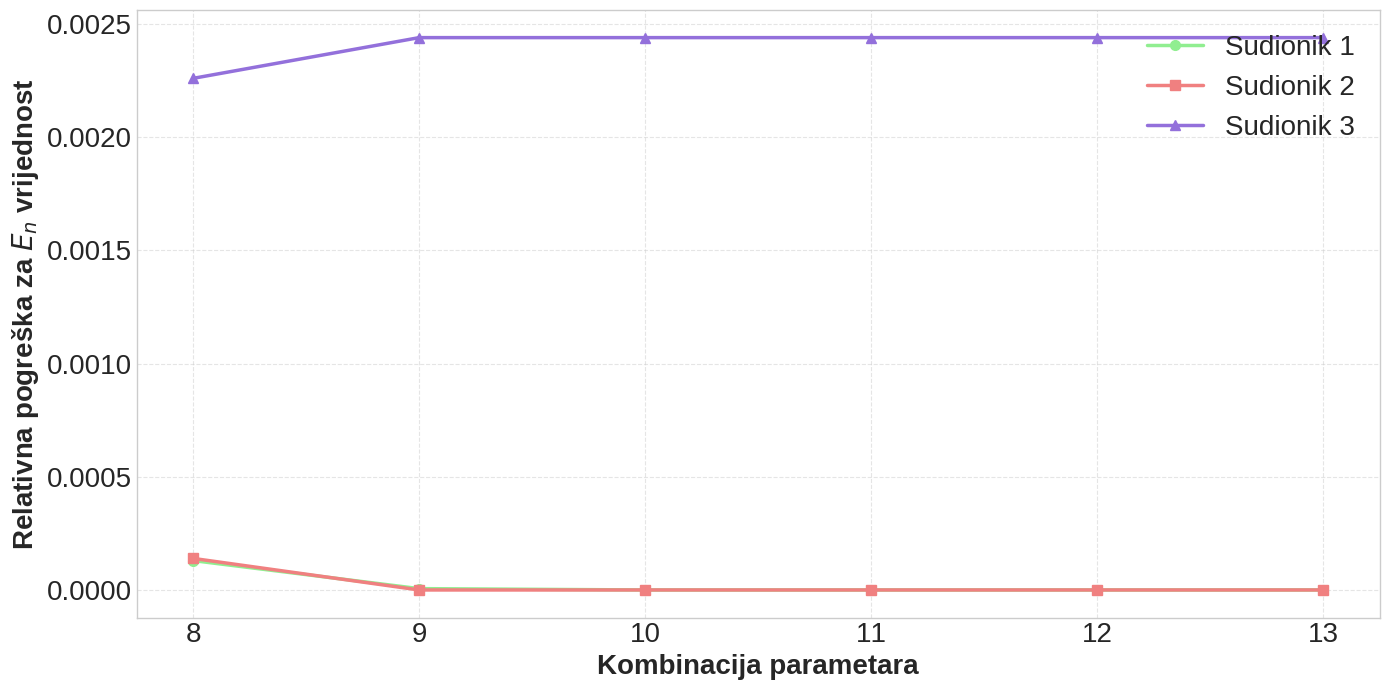

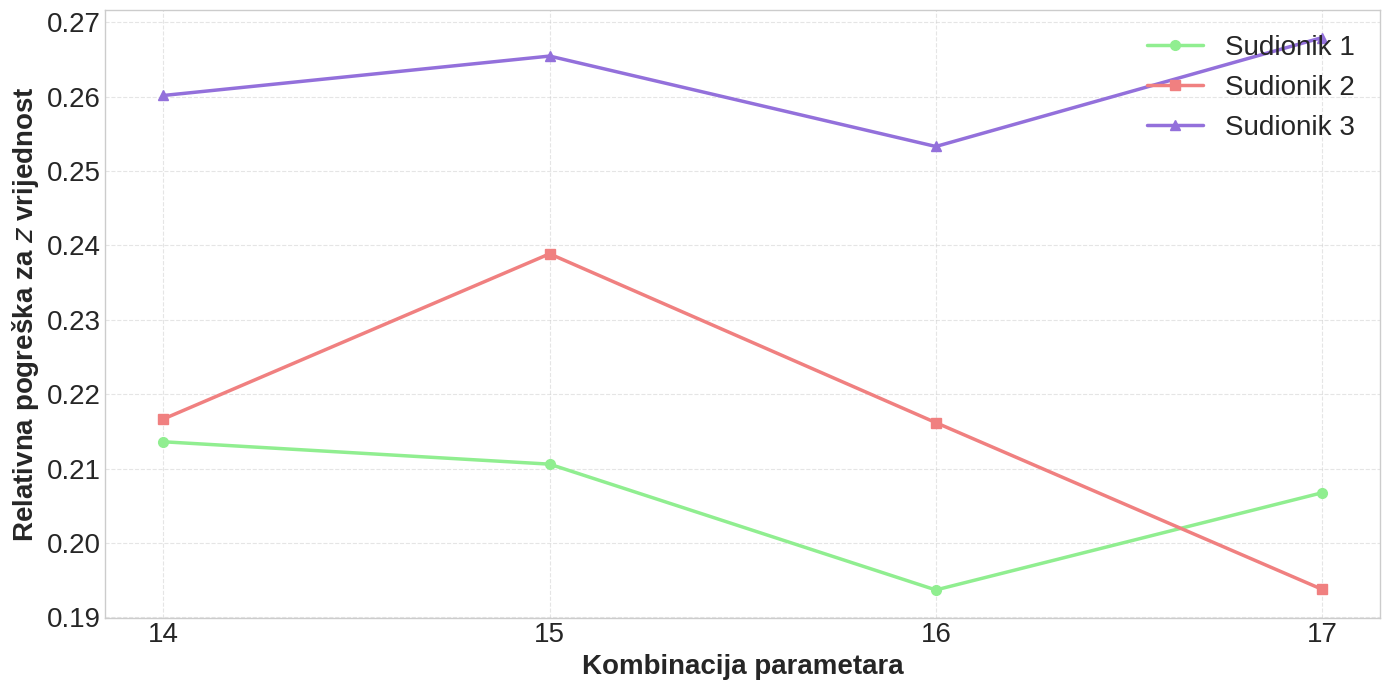

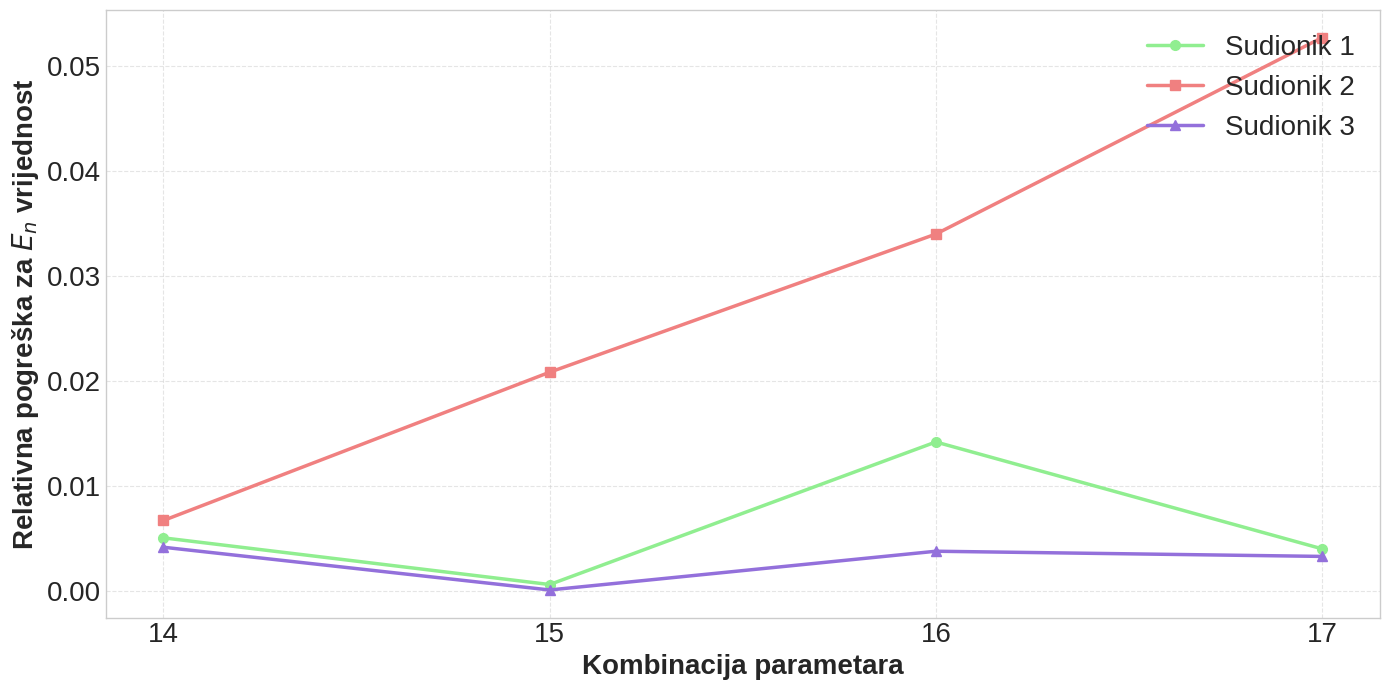

In [14]:
rel_err_z_p1 = relative_error(z_p1, z_ref_p1)
rel_err_z_p2 = relative_error(z_p2, z_ref_p2)
rel_err_z_p3 = relative_error(z_p3, z_ref_p3)

rel_err_en_p1 = relative_error(en_p1, en_ref_p1)
rel_err_en_p2 = relative_error(en_p2, en_ref_p2)
rel_err_en_p3 = relative_error(en_p3, en_ref_p3)

segments = [(0,7), (7,13), (13,17)]
labels_segments = [
    [f"{i+1}" for i in range(7)],
    [f"{i+1}" for i in range(7,13)],
    [f"{i+1}" for i in range(13,17)],
]

def plot_line_chart(labels, p1_vals, p2_vals, p3_vals, y_label, filename):
    x = np.arange(len(labels))
    plt.figure(figsize=(14,7))

    plt.plot(x, p1_vals, marker='o', markersize=7, linewidth=2.5,
             color='lightgreen', label='Sudionik 1')
    plt.plot(x, p2_vals, marker='s', markersize=7, linewidth=2.5,
             color='lightcoral', label='Sudionik 2')
    plt.plot(x, p3_vals, marker='^', markersize=7, linewidth=2.5,
             color='mediumpurple', label='Sudionik 3')

    plt.xlabel('Kombinacija parametara', fontsize=20, fontweight='bold')
    plt.ylabel(y_label, fontsize=20, fontweight='bold')

    plt.xticks(x, labels, fontsize=20)
    plt.yticks(fontsize=20)

    plt.legend(fontsize=20, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

for i, (start, end) in enumerate(segments):
    plot_line_chart(
        labels_segments[i],
        rel_err_z_p1[start:end],
        rel_err_z_p2[start:end],
        rel_err_z_p3[start:end],
        y_label="Relativna pogreška za $z$ vrijednost",
        filename=f"sol1_rel_error_z_segment_{i+1}.png"
    )
    plot_line_chart(
        labels_segments[i],
        rel_err_en_p1[start:end],
        rel_err_en_p2[start:end],
        rel_err_en_p3[start:end],
        y_label="Relativna pogreška za $E_n$ vrijednost",
        filename=f"sol1_rel_error_en_segment_{i+1}.png"
    )

Funkcija za izračun koeficijenta varijacije

In [15]:
def coeff_var(data):
    data = np.array(data)
    return (np.std(data) / np.abs(np.mean(data)))

Izračun i prikaz koeficijenta varijacije po segmentima

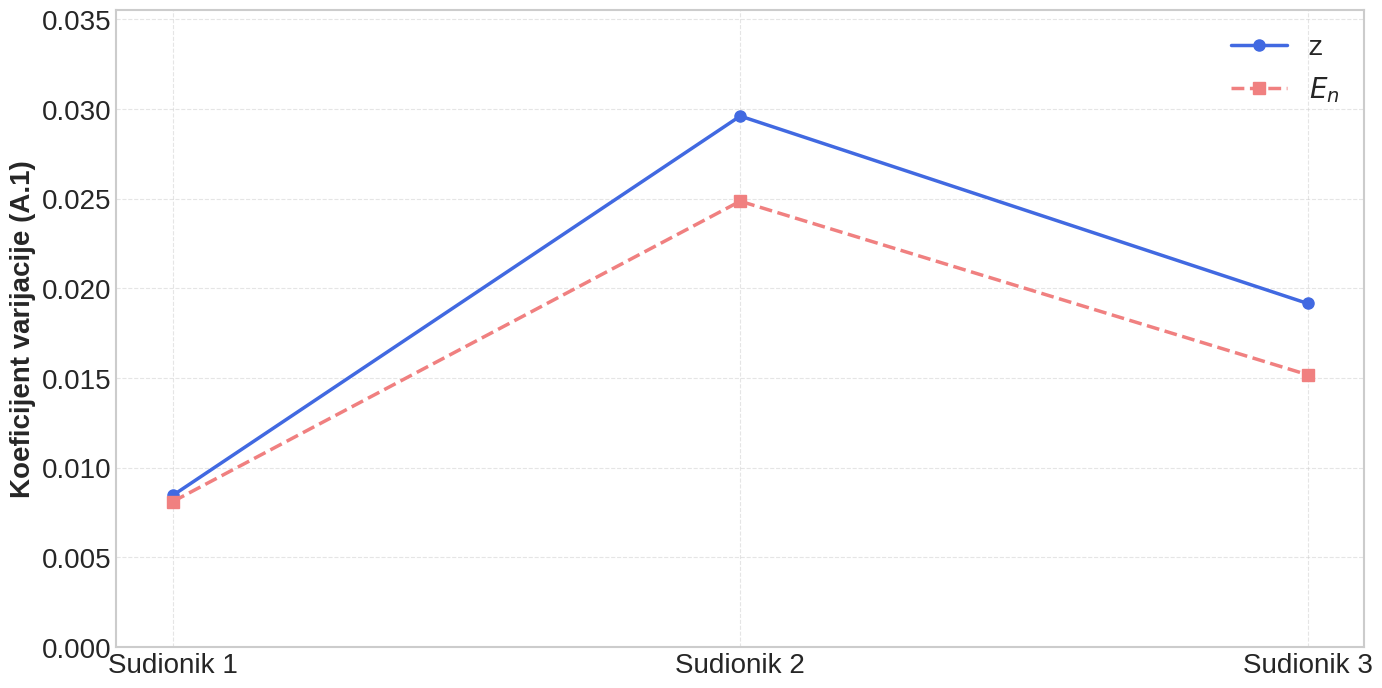

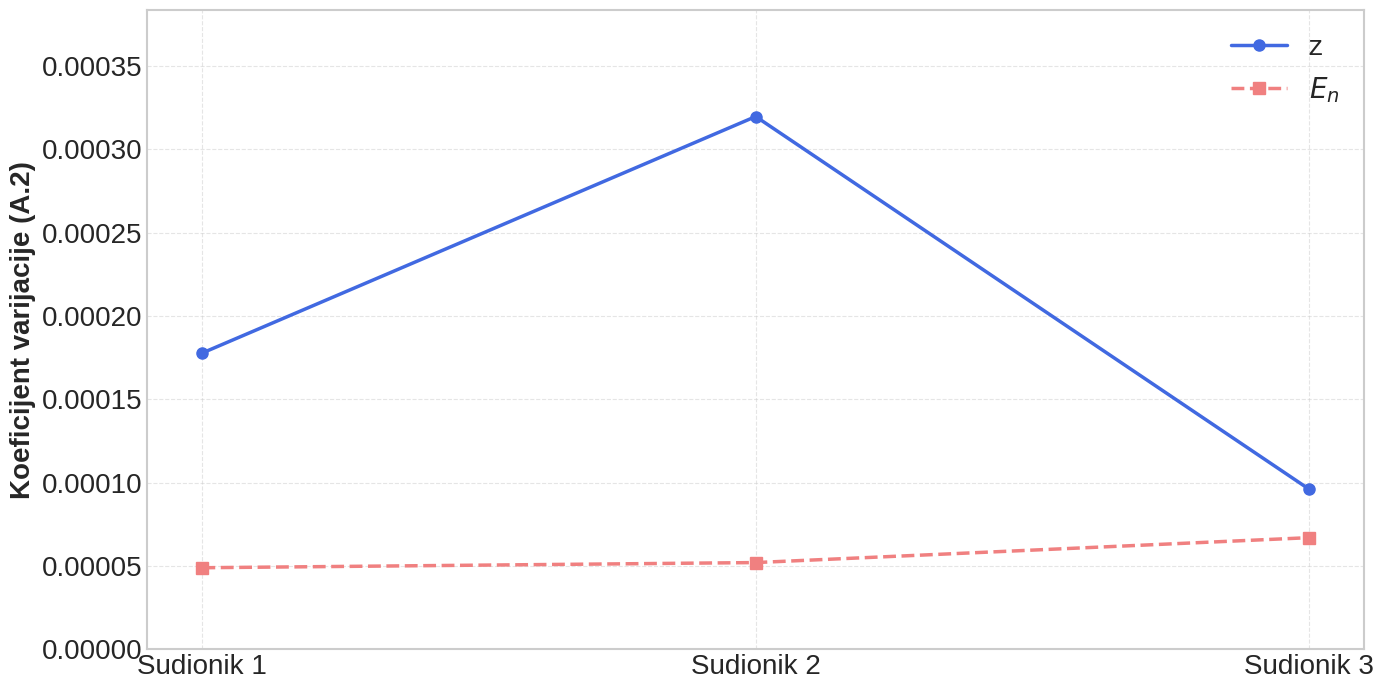

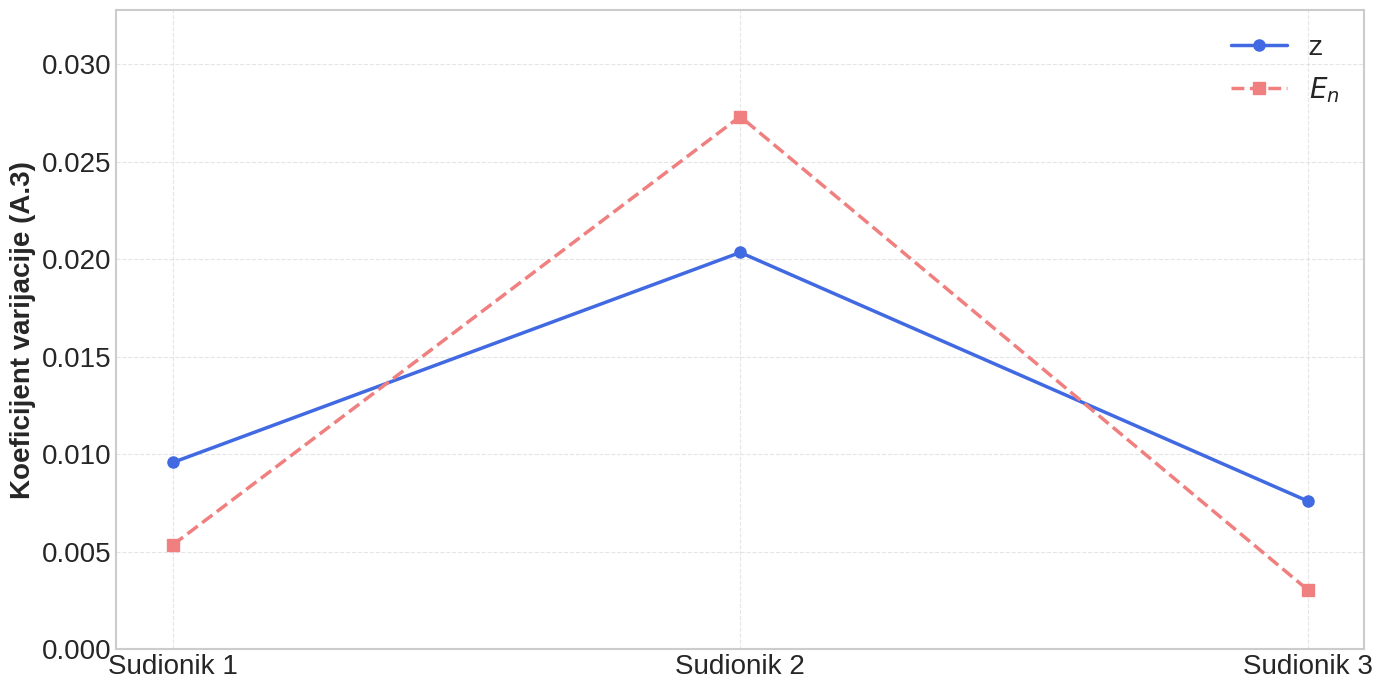

In [16]:
segments = [(0, 7), (7, 13), (13, 17)]
segment_labels = ['A.1', 'A.2', 'A.3']
z_data = [z_p1, z_p2, z_p3]
en_data = [en_p1, en_p2, en_p3]

z_cv = []
en_cv = []

for start, end in segments:
    z_cv.append([coeff_var(p[start:end]) for p in z_data])
    en_cv.append([coeff_var(p[start:end]) for p in en_data])

labels = ['Sudionik 1', 'Sudionik 2', 'Sudionik 3']

for i in range(3):
    plt.figure(figsize=(14, 7))
    ax = plt.gca()

    # Stilizirane linije
    plt.plot(labels, z_cv[i],
             marker='o', markersize=8,
             linewidth=2.5, linestyle='-',
             color='royalblue', label='z')

    plt.plot(labels, en_cv[i],
             marker='s', markersize=8,
             linewidth=2.5, linestyle='--',
             color='lightcoral', label=r'$E_n$')

    plt.ylabel(f'Koeficijent varijacije ({segment_labels[i]})', fontsize=20, fontweight='bold')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.ylim(0, max(max(z_cv[i]), max(en_cv[i])) * 1.2)

    plt.legend(fontsize=20, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.savefig(f'koeficijent_varijacije_obrazac_{i+1}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

Unos vrijednosti vremena izvođenja i prikaz za sve kombinacije parametara

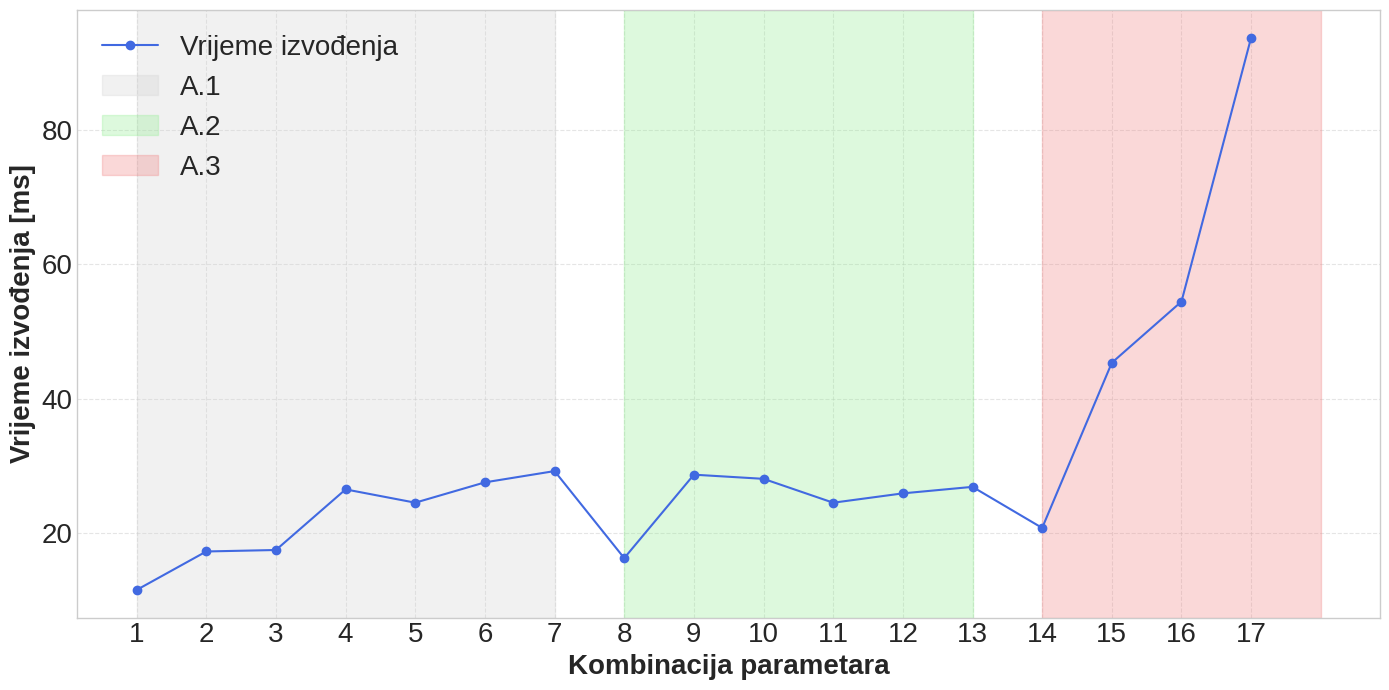

In [17]:
vrijeme_s = [
    0.011530, 0.017257, 0.017476, 0.026494, 0.024515, 0.027539, 0.029217,
    0.016267, 0.028683, 0.028063, 0.024512, 0.025902, 0.026870, 0.020759,
    0.045334, 0.054438, 0.093707
]

vrijeme_ms = [v * 1000 for v in vrijeme_s]

x = list(range(1, len(vrijeme_ms) + 1))

plt.figure(figsize=(14, 7))
plt.plot(x, vrijeme_ms, marker='o', linestyle='-', color='royalblue', label="Vrijeme izvođenja")

plt.axvspan(1, 7, color='lightgrey', alpha=0.3, label="A.1")
plt.axvspan(8, 13, color='lightgreen', alpha=0.3, label="A.2")
plt.axvspan(14, 18, color='lightcoral', alpha=0.3, label="A.3")

plt.xlabel("Kombinacija parametara", fontsize=20, fontweight='bold')
plt.ylabel("Vrijeme izvođenja [ms]", fontsize=20, fontweight='bold')

plt.xticks(x, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

plt.legend(fontsize=20, loc='upper left')

plt.tight_layout()
plt.savefig("vrijeme_izvođenja_sol1.png", dpi=300) 
plt.show()